In [423]:
import numpy as np
import pandas as pd
from matplotlib import gridspec
from matplotlib import pylab as plt

In [425]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Paths
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

In [104]:
# Basic variables from the data
age_full = pheno['AGE_AT_SCAN'].values
age_min = np.min(age_full)
age_max = np.max(age_full)
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]
site_number = len(site_list)
age_range = age_max - age_min

In [107]:
def gen_window(win_range, box_number, start_age):
    """
    Generate a window for the uniform sampling
    """
    # And the divisions between the boxes
    window = np.zeros((2,box_number))
    # Generate the lower edges of the boxes
    window[0,:] = np.linspace(0, win_range, box_number, endpoint=False) + start_age
    window[1,:] = np.linspace(window[0,1], win_range+start_age, box_number)
    
    return window

In [5]:
def get_boxsubs(site, window):
    """
    Returns a vector of subject numbers
    corresponding to the boxes in window
    """
    # Get the number of boxes in the window
    box_number = window.shape[1]
    # Convert the site into an array
    site = np.array(site)
    # Compute the number of subjects in each box
    box_subs = [np.sum(np.logical_and(site>window[0,idx],site<=window[1,idx])) for idx in np.arange(box_number)]
    # Convert the number of box subs into an array
    box_subs = np.array(box_subs)
    
    return box_subs

In [386]:
def opt_sites(site_subs, uniform=True):
    """
    Find the optimal sites to maximize number 
    of subjects
    
    """
    # Get the number of sites
    site_number = site_subs.shape[0]
    box_number = site_subs.shape[1]
    # Get the smallest number per box
    min_subs = np.min(site_subs,1)
    # Sort the sites by subjects per box
    site_sort = np.argsort(min_subs)
    # Find the position of the last site with 
    # zero subjects
    last_zero = np.argwhere(min_subs[site_sort]==0)[-1]
    # Iteratively remove sites and see if 
    # the total number of subjects improves
    sub_vec = np.zeros((site_number,))
    for idx in np.arange(last_zero,site_number):
        # Slice the sites
        tmp_site_idx = site_sort[idx:]
        # See if we want the same number from all
        # sites or just within sites
        if uniform:
            # Get the number of remaining sites
            tmp_site_number = len(tmp_site_idx)
            # Get the minimal number of subjects
            tmp_min = np.min(site_subs[tmp_site_idx,:])
            # Get the total number of subjects
            tmp_total = tmp_min * tmp_site_number * box_number
        else:
            # We take the sum across all the sites
            # since we already dropped the ones with 
            # zero subjects
            tmp_sum = np.sum(np.min(site_subs[tmp_site_idx,:],1))
            # Get the total number of subjects
            tmp_total = tmp_sum * box_number
        sub_vec[idx] = tmp_total
    # Find the set of sites with the largest number
    # of subjects
    if np.max(sub_vec)==0:
        # None of the sites contribute, throw them all out
        max_idx = site_number
    else:
        max_idx = np.argmax(sub_vec)
    sites = site_sort[max_idx:]
            
    return sites

In [527]:
def opt_subjects(site_list, win_range, box_number, age_full, uniform=True, n_windows=40):
    """
    Optimizes the number of subjects across sites
    by generating and shifting a window of ages
    divided into boxes
    
    Returns:
        number of subjects
        optimal window
        list of sites
    """
    # Find the minimal and maximal age values
    age_min = np.min(age_full)
    age_max = np.max(age_full)
    age_range = age_max - age_min
    # Compute the window step
    win_shift = age_range - win_range
    win_step = win_shift / n_windows
    # Compute the starting ages for the windows
    start_ages = np.arange(0,win_shift+0.1, win_step) + age_min
    
    # Prepare a list for the results
    res_list = list()
    sub_vec = np.zeros((n_windows))
    # Iterate through the different windows and 
    # find the maximum number of subjects
    for win_id in np.arange(n_windows):
        start_age = start_ages[win_id]
        # Generate the window
        window = gen_window(win_range, box_number, start_age)
        # Iterate through sites and collect number 
        # of subjects per box for all of them
        site_subs = np.zeros((site_number, box_number))
        for s_id, site in enumerate(site_list):
            site_subs[s_id, :] = get_boxsubs(site, window)

        # Find the optimal sites for this window and box
        sites = opt_sites(site_subs, uniform)
        # Check if any sites are left
        if sites.size:
            # Check if uniform
            if uniform:
                # Compute the total number of subjects
                min_sub = np.min(site_subs[sites,:])
                total_subjects = min_sub * len(sites) * box_number
                # Set all sites to the minimal value
                n_subs = np.tile(min_sub,(len(sites),))
            else:
                # Take the sum of the minimal subjects numbers
                # at each site
                n_subs = np.min(site_subs[sites,:],1)
                sum_sub = np.sum(n_subs)
                total_subjects = sum_sub * box_number
        else:
            # There are no sites left
            min_sub = 0
            total_subjects = 0
            n_subs = 0
        sub_vec[win_id] = total_subjects
        res_list.append((total_subjects, sites, n_subs, site_subs, window))
    
    # Get the optimal number of subjects
    max_sub_id = np.argmax(sub_vec)
    best_result = res_list[max_sub_id]
    
    return best_result

## Draw an actual sample
So far, things have been quite theoretical. Let's get the details of the theoretical sample and make an actual list of subjects to be sure that we can really get a uniform sample of over 600 subjects.

First, I will change the function to return some information on the sample with the optimal number

In [404]:
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

age_full = pheno['AGE_AT_SCAN'].values
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]

windows = np.arange(1,30,0.5)
n_windows = len(windows)
boxes = np.arange(2,30)
n_boxes = len(boxes)

results = np.zeros((n_windows, n_boxes))
sites = np.zeros((n_windows, n_boxes))
res_list = list()
iter_id = 0
for w_id, win_range in enumerate(windows):
    for b_id, box_number in enumerate(boxes):
        res = opt_subjects(site_list, win_range, box_number, age_full, False)
        res_list.append(res)
        results[w_id, b_id] = res[0]
        sites[w_id, b_id] = len(res[1])

In [405]:
# Find the absolute maximum number of subjects
np.max(results)

480.0

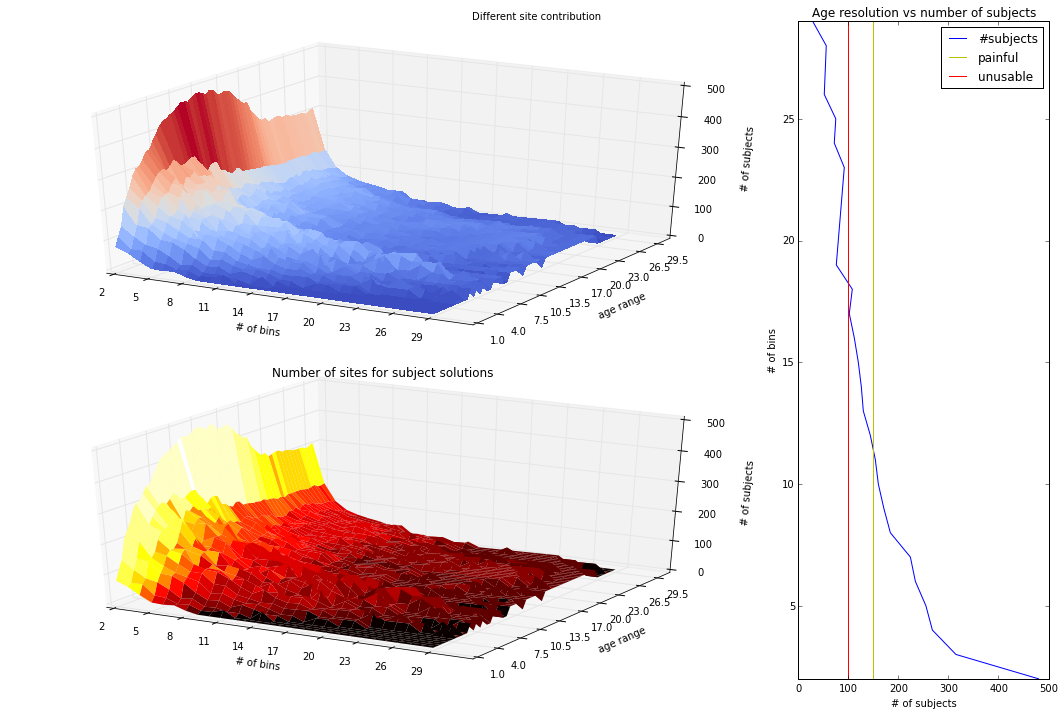

In [453]:
# Prepare stuff
x_ticks = np.round(np.linspace(0,len(boxes)-1,10))
x_labels = np.array([boxes[ind] for ind in x_ticks])
y_ticks = np.round(np.linspace(0,len(windows)-1,10))
y_labels = np.array([windows[ind] for ind in y_ticks])
a, b = results.T.shape
X, Y = np.mgrid[:a, :b]
N = sites/np.max(sites)

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 
# Make the subject overview
ax1 = fig.add_subplot(gs[0,0], projection='3d')
surf = ax1.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_labels)
ax1.set_xlabel('# of bins')
ax1.set_ylabel('age range')
ax1.set_zlabel('# of subjects')

# Make the site overview
ax = fig.add_subplot(gs[1,0], projection='3d')
surf = ax.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,facecolors=cm.hot(N.T),
        linewidth=0, antialiased=True)
colmap = cm.ScalarMappable(cmap=cm.hot)
colmap.set_array(sites.T)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xlabel('# of bins')
ax.set_ylabel('age range')
ax.set_zlabel('# of subjects')
ax.set_title('Number of sites for subject solutions')

# Show the boxes over subjects
ax3 = fig.add_subplot(gs[:,1])
ax3.plot(np.max(results,0),boxes, label='#subjects')
ax3.axvline(x=150, color='y', label='painful')
ax3.axvline(x=100, color='r', label='unusable')
ax3.set_ylim([np.min(boxes), np.max(boxes)])
ax3.set_xlabel('# of subjects')
ax3.set_ylabel('# of bins')
ax3.legend()
ax3.set_title('Age resolution vs number of subjects')
plt.tight_layout()
fig.suptitle('Different site contribution')

In [528]:
pheno_path = '/data1/abide/Pheno/pheno.csv'
pheno = pd.read_csv(pheno_path)

age_full = pheno['AGE_AT_SCAN'].values
site_list = [list(pheno.loc[pheno['SITE_ID'] == val]['AGE_AT_SCAN'].values) for val in pheno['SITE_ID'].unique()]

windows = np.arange(1,30,0.5)
n_windows = len(windows)
boxes = np.arange(2,30)
n_boxes = len(boxes)

results = np.zeros((n_windows, n_boxes))
sites = np.zeros((n_windows, n_boxes))
res_list = list()
iter_id = 0
for w_id, win_range in enumerate(windows):
    for b_id, box_number in enumerate(boxes):
        res = opt_subjects(site_list, win_range, box_number, age_full, True)
        res_list.append(res)
        results[w_id, b_id] = res[0]
        sites[w_id, b_id] = len(res[1])

In [529]:
# Find the absolute maximum number of subjects
np.max(results)

264.0

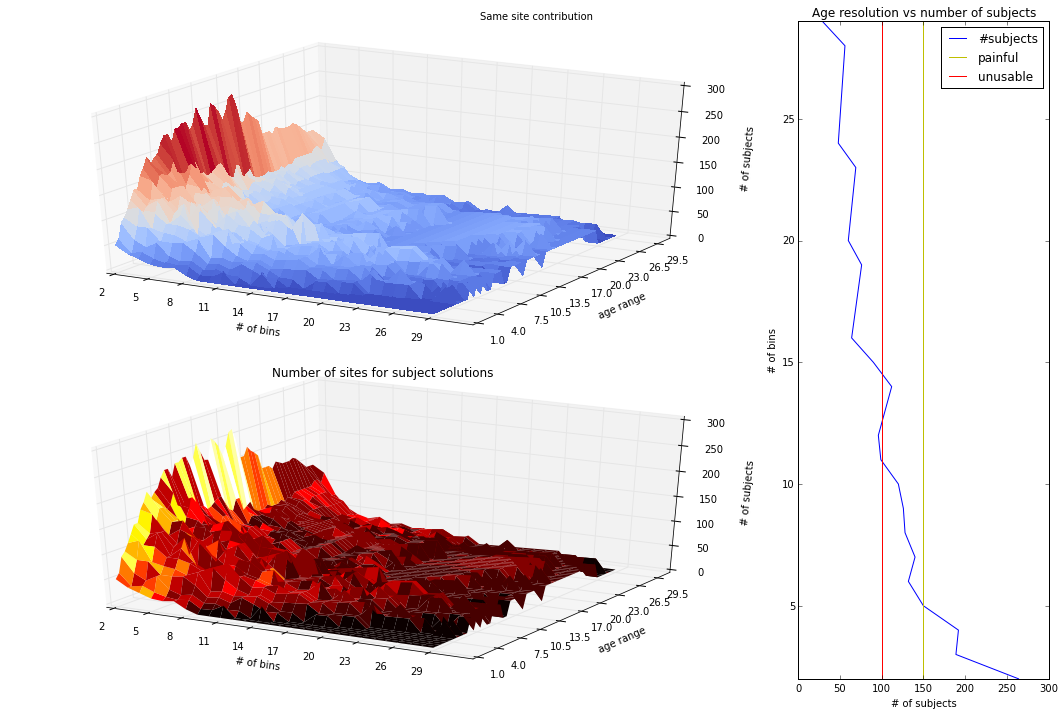

In [530]:
# Prepare stuff
x_ticks = np.round(np.linspace(0,len(boxes)-1,10))
x_labels = np.array([boxes[ind] for ind in x_ticks])
y_ticks = np.round(np.linspace(0,len(windows)-1,10))
y_labels = np.array([windows[ind] for ind in y_ticks])
a, b = results.T.shape
X, Y = np.mgrid[:a, :b]
N = sites/np.max(sites)

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 
# Make the subject overview
ax1 = fig.add_subplot(gs[0,0], projection='3d')
surf = ax1.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_labels)
ax1.set_xlabel('# of bins')
ax1.set_ylabel('age range')
ax1.set_zlabel('# of subjects')

# Make the site overview
ax = fig.add_subplot(gs[1,0], projection='3d')
surf = ax.plot_surface(X,Y,results.T,rstride=1, cstride=1, cmap=cm.coolwarm,facecolors=cm.hot(N.T),
        linewidth=0, antialiased=True)
colmap = cm.ScalarMappable(cmap=cm.hot)
colmap.set_array(sites.T)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_labels)
ax.set_xlabel('# of bins')
ax.set_ylabel('age range')
ax.set_zlabel('# of subjects')
ax.set_title('Number of sites for subject solutions')

# Show the boxes over subjects
ax3 = fig.add_subplot(gs[:,1])
ax3.plot(np.max(results,0),boxes, label='#subjects')
ax3.axvline(x=150, color='y', label='painful')
ax3.axvline(x=100, color='r', label='unusable')
ax3.set_ylim([np.min(boxes), np.max(boxes)])
ax3.set_xlabel('# of subjects')
ax3.set_ylabel('# of bins')
ax3.legend()
ax3.set_title('Age resolution vs number of subjects')
plt.tight_layout()
fig.suptitle('Same site contribution')

Generate two windows, one with lowres, highsub and one with highres, lowsub. I'll call them lr for lowres and hr for highres.

__Lowres__: This is the local maximum with 4 boxes  
__Highres__: This is the local maximum with 14 boxes

Now the question is which window range we have to pick. We have the boxes coordinates for each of the two solutions. Within the vector I can then retrieve the window range coordinates.

In [561]:
# Get all the site names
all_sites = pheno['SITE_ID'].unique()
# Box coordinates for both samples
lr_b = 2
hr_b = 12
# Retrieve the window coordinates for the samples
lr_w = np.argmax(results[:, lr_b])
hr_w = np.argmax(results[:, hr_b])
# Make the full coordinates
lr_c = (lr_w, lr_b)
hr_c = (hr_w, hr_b)
# Get the flat coordinates back
lr_ind = np.ravel_multi_index(lr_c, results.shape)
hr_ind = np.ravel_multi_index(hr_c, results.shape)
# Get the results
# total_subjects, sites, n_subs, site_subs, window
lr_res = res_list[lr_ind]
hr_res = res_list[hr_ind]
# Get the windows
lr_win = lr_res[4]
hr_win = hr_res[4]
# Get the sites IDs
lr_site_id = lr_res[1]
hr_site_id = hr_res[1]
# Get the site names
lr_sites = list(all_sites[lr_site_id])
hr_sites = list(all_sites[hr_site_id])
# Get the number of subjects
lr_nsubs = lr_res[2]
hr_nsubs = hr_res[2]

In [671]:
def get_sample(pheno, site_names, n_subs, window):
    """
    Generate a random draw from the selected site
    names with the specified window and n_subs in 
    each bin.
    
    pheno: pandas dataframe
    site_names: list of strings corresponding to sites
    n_subs : vector of length #sites with subjects per bin
    window: 2*X array where X is the the number of bins+1
    """
    # Prepare list to store the IDs in
    sub_ids = list()
    # Iterate through the sites
    for s_id, site in enumerate(site_names):
        # Get bin number for this site
        site_subs = n_subs[s_id]
        # Get slice of pheno for this site
        sphen = pheno.loc[pheno['SITE_ID']==site]
        # Iterate through the boxes of the window
        for b_id, box in enumerate(window.T):
            start = box[0]
            stop = box[1]
            # Get the indices of all subjects in this range
            range_ids = np.logical_and(sphen['AGE_AT_SCAN'].values>start, sphen['AGE_AT_SCAN'].values<=stop)
            # Get the corresponding subjects IDs
            range_subs = sphen['SUB_ID'].values[range_ids]
            # Make sure we have at least site_subs
            if len(range_subs) < site_subs:
                raise Exception('Fewer than {} subjects between {} and {} in site {}'.format(site_subs,
                                                                                            start,
                                                                                            stop,
                                                                                            site))
            # Draw a random subsample of the subjects IDs
            np.random.shuffle(range_subs)
            sel_indices = list(range_subs[:site_subs])
            sub_ids = sub_ids + sel_indices
    return sub_ids

In [857]:
def summarize_sample(pheno, indices, window, spacer=0.2):
    """
    Summarize the sample
    """
    # Get the pheno data for the reported indices
    sel_pheno = pheno[pheno['SUB_ID'].isin(indices)]
    ages = sel_pheno['AGE_AT_SCAN'].values
    # Group the pheno by site
    grouped = sel_pheno.groupby('SITE_ID')
    # Get the site names
    site_names = grouped.groups.keys()
    # Get a list of the ages in the sample by site
    age_list = [grouped.get_group(st)['AGE_AT_SCAN'].values for st in site_names]
    # Generate the bins from the window
    #bins = np.append(window[0,:], window[1,-1])
    # More interesting bins
    bins = np.linspace(np.min(ages), np.max(ages),20)
    # Plot the results
    gs = gridspec.GridSpec(2, 2, top=0.98, wspace=0.5, hspace=0.5, height_ratios=[1,1.5]) 
    f = plt.figure(figsize=(10,5))
    
    ax1 = f.add_subplot(gs[0,0])
    ax1.hist(age_list, bins,stacked=True, normed = False, label=site_names)
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1),
               fancybox=True, shadow=False, ncol=1)
    
    # Get the general sample
    # First get the subjects not in the sample
    nonsam = pheno[~pheno['SUB_ID'].isin(indices)]
    all_group = nonsam.groupby('SITE_ID')
    site_names_nosam = all_group.groups.keys()

    n_sites = len(site_names_nosam)
    # Generate the site index
    site_ind = np.arange(1,n_sites+1)
    ind_dict = dict()
    for s_id, site in enumerate(site_names_nosam):
        ind_dict[site] = site_ind[s_id]

    all_ages_nosam = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names_nosam]

    ax2 = f.add_subplot(gs[1,:])
    for idx, ages in enumerate(all_ages_nosam):
        site_name = site_names_nosam[idx]
        l_ages = len(ages)
        ind = np.ones((l_ages,))*ind_dict[site_name]
        jitter = (np.random.random(l_ages,)*2-1)*spacer
        ind += jitter
        tmp = ax2.plot(ind, ages, 'ko')
    # Kinda sketchy but what the hell
    tmp = ax2.plot(ind, ages, 'ko',label='not included')


    # Now add the guys that belong to the sample
    sam = pheno[pheno['SUB_ID'].isin(indices)]
    all_group = sam.groupby('SITE_ID')
    site_names_sam = all_group.groups.keys()
    all_ages_sam = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names_sam]

    for idx, ages in enumerate(all_ages_sam):
        site_name = site_names_sam[idx]
        l_ages = len(ages)
        ind = np.ones((l_ages,))*ind_dict[site_name]
        jitter = (np.random.random(l_ages,)*2-1)*spacer
        ind += jitter
        tmp = ax2.plot(ind, ages, 'ro')
    # Kinda sketchy but what the hell
    tmp = ax2.plot(ind, ages, 'ro', label='included')

    tmp = ax2.set_xticks(site_ind)
    tmp = ax2.set_xticklabels(site_names_nosam, rotation=70)
    tmp = ax2.legend(loc='upper left', bbox_to_anchor=(1, 1),
               fancybox=True, shadow=False, ncol=1)
    
    # Plot the violin plots too
    ax3 = f.add_subplot(gs[0,1])
    violin_ind = np.arange(1,len(site_names_sam)+1)
    ax3.violinplot(age_list, violin_ind)
    tmp = ax3.set_xticks(violin_ind)
    tmp = ax3.set_xticklabels(site_names_sam, rotation=70)

In [822]:
a = get_sample(pheno, hr_sites, hr_nsubs, hr_win)

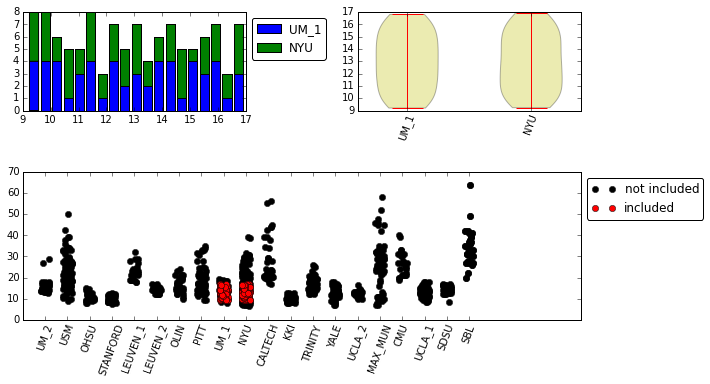

In [858]:
x = summarize_sample(pheno, a, hr_win)

In [842]:
x

(array([1, 2]), ['UM_1', 'NYU'])

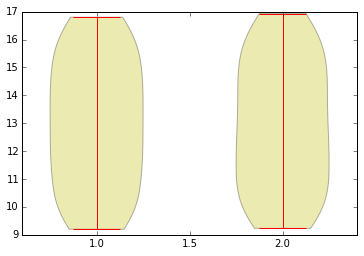

In [847]:
f = plt.figure()
ax = f.add_subplot(111)
ind = np.arange(1,len(x[1])+1)
tmp = ax.violinplot(x[2],ind)


In [848]:
ind

array([1, 2])

In [683]:
b = pheno[pheno['SUB_ID'].isin(a)]

In [684]:
c = b.groupby('SITE_ID')

In [685]:
res = [c.get_group(st)['AGE_AT_SCAN'].values for st in c.groups.keys()]

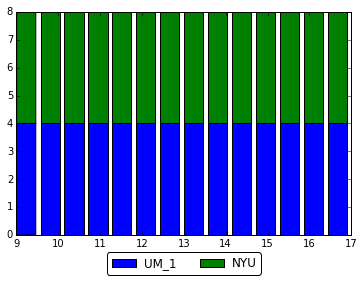

In [811]:
bins = np.append(hr_win[0,:], hr_win[1,-1])
plt.hist(res, bins,stacked=True, normed = False, label=c.groups.keys())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=False, ncol=2)

{u'bodies': [<matplotlib.collections.PolyCollection at 0x3f64c2d0>,
 u'cbars': <matplotlib.collections.LineCollection at 0x3ac08450>,
 u'cmaxes': <matplotlib.collections.LineCollection at 0x3f64cc50>,
 u'cmins': <matplotlib.collections.LineCollection at 0x3ac0d790>}

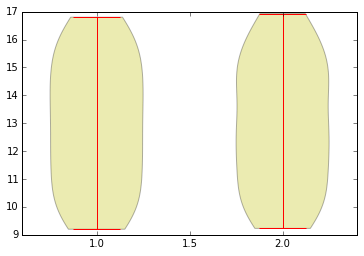

In [812]:
# Try a violin plot
plt.violinplot(res)

([<matplotlib.axis.XTick at 0x360f3110>,
 <a list of 2 Text xticklabel objects>)

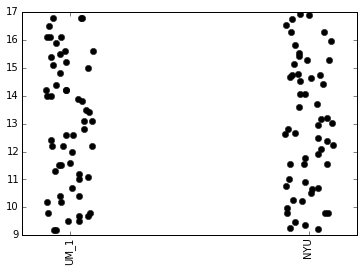

In [713]:
# Plot the boxplots here
site_names = c.groups.keys()
for i, r in enumerate(res):
    l = len(r)
    ind = np.ones((l,))*(i+1)
    np.random.seed(1)
    jitter = (np.random.random(l,)*2-1)*.1
    ind += jitter
    plt.plot(ind, r, 'ko')
plt.xticks([1,2], site_names, rotation='vertical')

In [715]:
q = pheno[~pheno['SUB_ID'].isin(a)]

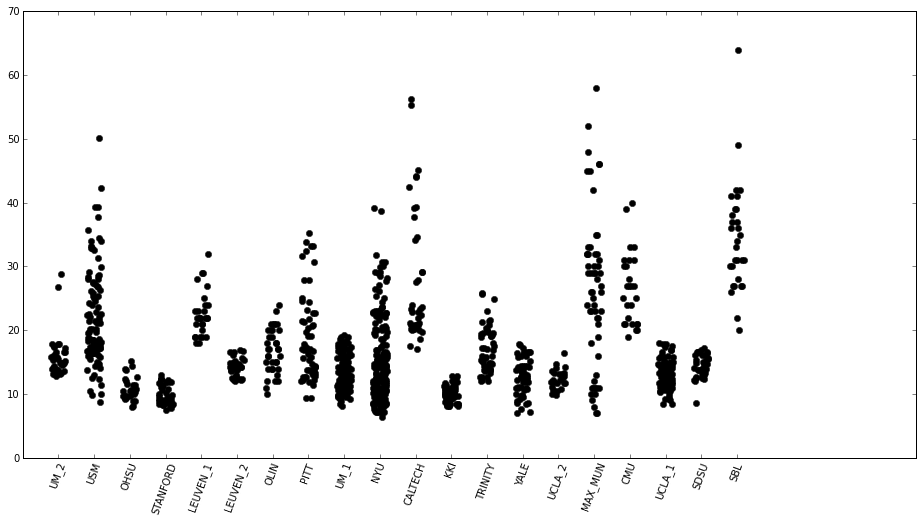

In [813]:
# Display all the ages of all the sites
all_group = pheno.groupby('SITE_ID')
site_names = all_group.groups.keys()
n_sites = len(site_names)
all_ages = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names]

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
for idx, ages in enumerate(all_ages):
    l_ages = len(ages)
    ind = np.ones((l_ages,))*(idx+1)
    jitter = (np.random.random(l_ages,)*2-1)*.2
    ind += jitter
    x = ax.plot(ind, ages, 'ko')
x= ax.set_xticks(np.arange(1,(n_sites+1)))
x= ax.set_xticklabels(site_names, rotation=70)

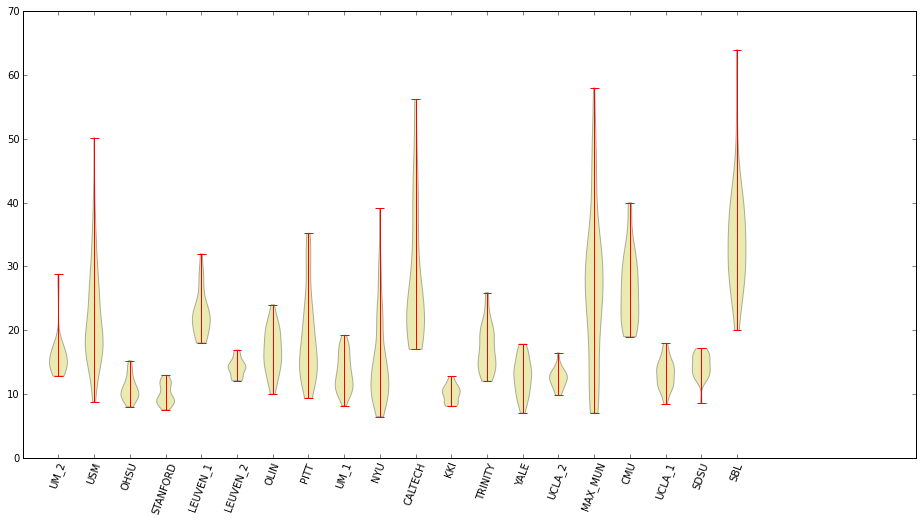

In [814]:
# Display all the ages of all the sites
all_group = pheno.groupby('SITE_ID')
site_names = all_group.groups.keys()
n_sites = len(site_names)
site_ind = np.arange(1,n_sites+1)
all_ages = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names]

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
ax.violinplot(all_ages, site_ind)
x= ax.set_xticks(np.arange(1,(n_sites+1)))
x= ax.set_xticklabels(site_names, rotation=70)

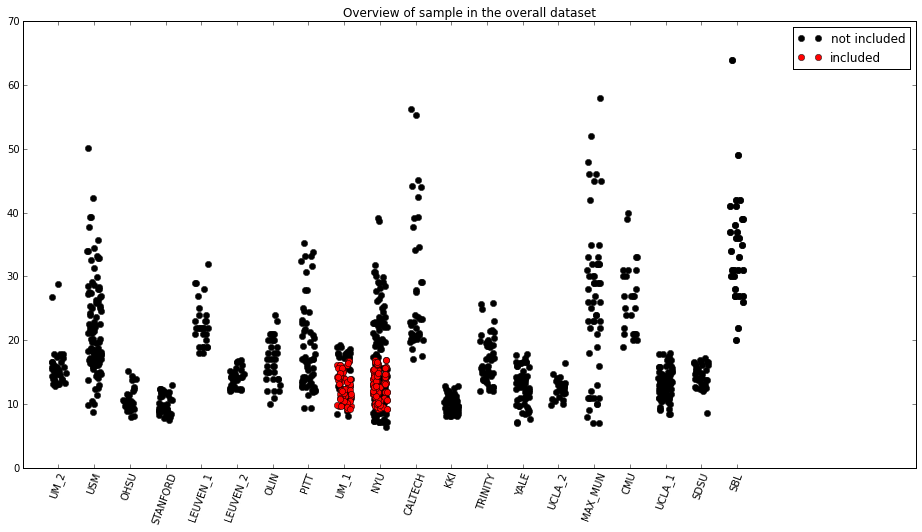

In [766]:
# Now display all subjects and overlay the sample
nonsam = pheno[~pheno['SUB_ID'].isin(a)]
all_group = nonsam.groupby('SITE_ID')
site_names_nosam = all_group.groups.keys()

spacer = .2
n_sites = len(site_names)
# Generate the site index
site_ind = np.arange(1,n_sites+1)
ind_dict = dict()
for s_id, site in enumerate(site_names_nosam):
    ind_dict[site] = site_ind[s_id]

all_ages_nosam = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names_nosam]

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)
for idx, ages in enumerate(all_ages_nosam):
    site_name = site_names_nosam[idx]
    l_ages = len(ages)
    ind = np.ones((l_ages,))*ind_dict[site_name]
    jitter = (np.random.random(l_ages,)*2-1)*spacer
    ind += jitter
    x = ax.plot(ind, ages, 'ko')
# Kinda sketchy but what the hell
x = ax.plot(ind, ages, 'ko',label='not included')


# Now add the guys that belong to the sample
sam = pheno[pheno['SUB_ID'].isin(a)]
all_group = sam.groupby('SITE_ID')
site_names_sam = all_group.groups.keys()
all_ages_sam = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names_sam]

for idx, ages in enumerate(all_ages_sam):
    site_name = site_names_sam[idx]
    l_ages = len(ages)
    ind = np.ones((l_ages,))*ind_dict[site_name]
    jitter = (np.random.random(l_ages,)*2-1)*spacer
    ind += jitter
    x = ax.plot(ind, ages, 'ro')
# Kinda sketchy but what the hell
x = ax.plot(ind, ages, 'ro', label='included')
    
x= ax.set_xticks(site_ind)
x= ax.set_xticklabels(site_names_nosam, rotation=70)
x = ax.legend()
x = ax.set_title('Overview of sample in the overall dataset')

In [687]:
# Visualize all ages in boxplots by sites
all_group = pheno.groupby('SITE_ID')
site_names = all_group.groups.keys()
all_ages = [all_group.get_group(st)['AGE_AT_SCAN'].values for st in site_names]

for i, r in enumerate(res):
    l = len(r)
    ind = np.ones((l,))*(i+1)
    np.random.seed(1)
    jitter = (np.random.random(l,)*2-1)*.1
    ind += jitter
    plt.plot(ind, r, 'ko')
plt.xticks([1,2], site_names, rotation='vertical')

In [644]:
bins = np.append(lr_win[0,:], lr_win[1,-1])

In [645]:
lr_win

array([[  8.8965,  11.1465,  13.3965,  15.6465],
       [ 11.1465,  13.3965,  15.6465,  17.8965]])

In [646]:
res

[array([ 12.75,  10.67,  13.75,  12.25,  13.33,  10.83,  13.92,  11.  ,
         13.92,  11.  ,  10.92,  12.33,  13.25,  13.  ,  11.92,  11.83,
         11.83,  12.75,  12.75,  13.66,  11.08]),
 array([ 13.52,  11.56,  10.41,  11.56,  10.54,  11.81,  12.99,  12.33,
         12.75,  10.91,  12.42,  10.85,  13.67,  10.9 ,  11.69,  13.09,
         11.97,  12.36,  10.99,  13.38,  11.55,  11.07,  13.66,  11.56,
         13.46,  13.41,  12.68,  10.96,  13.85,  13.82,  11.83,  12.73]),
 array([ 11.5,  11.3,  10.7,  11.2,  11.2,  12.8,  11.2,  14. ,  13.9,
         12.6,  12.6,  12.2,  10.4,  11.6,  11. ,  10.9,  11.2,  13.4,
         13.4,  11.8,  13.8,  13.1,  12. ,  10.4,  10.2,  11. ,  11.8,
         12.6,  13.8,  10.9,  12.8,  10.2,  11.6,  11.5,  11.6]),
 array([ 11.764,  12.64 ,  10.23 ,  12.75 ,  10.24 ,  13.95 ,  13.09 ,
         10.66 ,  10.87 ,  13.33 ,  10.71 ,  11.11 ,  12.37 ,  10.65 ,
         10.27 ,  11.56 ,  12.1  ,  13.22 ,  10.69 ,  11.91 ,  12.49 ,
         12.81 ,  10.46 

In [649]:
b['AGE_AT_SCAN'].values

array([ 11.764,  12.64 ,  10.23 ,  12.75 ,  10.24 ,  13.95 ,  13.09 ,
        10.66 ,  10.87 ,  13.33 ,  10.71 ,  11.11 ,  12.37 ,  10.65 ,
        10.27 ,  11.56 ,  12.1  ,  13.22 ,  10.69 ,  11.91 ,  12.49 ,
        12.81 ,  10.46 ,  10.52 ,  10.73 ,  10.76 ,  11.69 ,  12.1  ,
        13.18 ,  13.72 ,  10.19 ,  10.74 ,  11.92 ,  12.07 ,  12.67 ,
        12.81 ,  13.52 ,  11.56 ,  10.41 ,  11.56 ,  10.54 ,  11.81 ,
        12.99 ,  12.33 ,  12.75 ,  10.91 ,  12.42 ,  10.85 ,  13.67 ,
        10.9  ,  11.69 ,  13.09 ,  11.97 ,  12.36 ,  10.99 ,  13.38 ,
        11.55 ,  11.07 ,  13.66 ,  11.56 ,  13.46 ,  13.41 ,  12.68 ,
        10.96 ,  13.85 ,  13.82 ,  11.83 ,  12.73 ,  11.5  ,  11.3  ,
        10.7  ,  11.2  ,  11.2  ,  12.8  ,  11.2  ,  14.   ,  13.9  ,
        12.6  ,  12.6  ,  12.2  ,  10.4  ,  11.6  ,  11.   ,  10.9  ,
        11.2  ,  13.4  ,  13.4  ,  11.8  ,  13.8  ,  13.1  ,  12.   ,
        10.4  ,  10.2  ,  11.   ,  11.8  ,  12.6  ,  13.8  ,  10.9  ,
        12.8  ,  10.

In [638]:
bins

array([  8.8965,  11.1465,  13.3965,  15.6465,  17.8965])

In [639]:
c.groups.keys()

['YALE', 'UCLA_1', 'UM_1', 'NYU']

In [640]:
lr_sites

['YALE', 'UCLA_1', 'UM_1', 'NYU']

(array([ 12.,  17.,  14.,  12.,  13.,   9.,  17.,   7.,   9.,  14.]),
 array([ 10.19 ,  10.571,  10.952,  11.333,  11.714,  12.095,  12.476,
         12.857,  13.238,  13.619,  14.   ]),
 <a list of 10 Patch objects>)

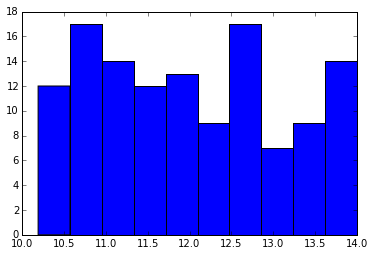

In [605]:
plt.hist(b_age)

In [585]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [586]:
np.random.shuffle(a)

In [587]:
a

array([4, 5, 8, 1, 9, 2, 7, 6, 0, 3])

In [569]:
for i in a.T:
    print i

[0 5]
[1 6]
[2 7]
[3 8]
[4 9]


In [582]:
range_ids = np.logical_and(a['AGE_AT_SCAN'].values>10, a['AGE_AT_SCAN'].values<=14)

In [583]:
range_ids

array([False,  True, False, False, False,  True, False,  True,  True,
       False,  True,  True,  True, False,  True, False, False,  True,
       False, False,  True, False, False,  True,  True, False, False,
        True, False, False,  True, False, False, False, False, False,
       False,  True,  True,  True,  True, False, False,  True, False,
        True, False,  True, False, False,  True,  True, False,  True,
       False, False], dtype=bool)

In [ ]:
np.random.shuffle

In [570]:
a = pheno.loc[pheno['SITE_ID']=='YALE']

In [578]:
a['SUB_ID'].values[a['AGE_AT_SCAN'].values>10]

array([50551, 50552, 50555, 50556, 50557, 50558, 50559, 50561, 50562,
       50563, 50565, 50567, 50568, 50569, 50570, 50571, 50572, 50573,
       50574, 50575, 50577, 50578, 50601, 50603, 50604, 50605, 50606,
       50607, 50608, 50610, 50611, 50612, 50613, 50614, 50616, 50618,
       50619, 50620, 50621, 50623, 50624, 50626, 50628])

In [576]:
pheno.head()

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.4,1,R,NaN,126,118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.9,1,Ambi,NaN,107,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.2,1,R,NaN,93,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.8,1,R,NaN,106,94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.6,2,Ambi,NaN,133,135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


Get the optimal result from the results array. I'll get the 1D and the 2D index

In [478]:
ind2D = np.unravel_index(results.argmax(), results.shape)
ind1D = np.argmax(results)

In [487]:
np.ravel(ind1D, results.shape)

array([952])

Find the window length and the number of boxes

In [265]:
# Summary of optimal results
sub_num = results[ind2D]
window_length = windows[ind2D[0]]
box_number = boxes[ind2D[1]]
site_num = len(res_list[ind1D][1])
good_sites = list(pheno['SITE_ID'].unique()[res_list[ind1D][1]])
min_sub = res_list[ind1D][3]
print('Optimal Results:\n'
      '  number of subjects: {}\n'
      '  window length: {}\n'
      '  box number: {}\n'
      '  min sub: {}\n'
      '  site number: {}\n'
      '  sites: {}'.format(sub_num, window_length,
                           box_number, min_sub,
                           site_num,good_sites))

Optimal Results:
  number of subjects: 264.0
  window length: 18.0
  box number: 2
  min sub: 12.0
  site number: 11
  sites: ['SDSU', 'YALE', 'MAX_MUN', 'OLIN', 'UCLA_1', 'UM_2', 'USM', 'TRINITY', 'PITT', 'UM_1', 'NYU']


All nice and dandy but let's try to not force all sites to have the same amount of subjects in the cells and include anyone as long as they are all uniform within the boxes within a site.